<a href="https://colab.research.google.com/github/Abkhenaten/Natural-Language-Procesing/blob/master/BBC_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text classification techniques to solve BBC news article categorization problems.
To solve the problems I will use Python, Sci-kit-learn, Gensim and XGboost.

In [1]:
import gensim.parsing.preprocessing as gsp
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from gensim import utils
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn import utils as skl_utils
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from wordcloud import WordCloud

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bbc_text = pd.read_csv('/content/drive/My Drive/bbc-text.csv')

The dataset contains BBC news text in a two-column csv format.

In [4]:
bbc_text.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


The problem is: if a ‘text’ is given, predict its ‘category’. A multi-class text classification problem.

##Data Exploration and Visualization

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

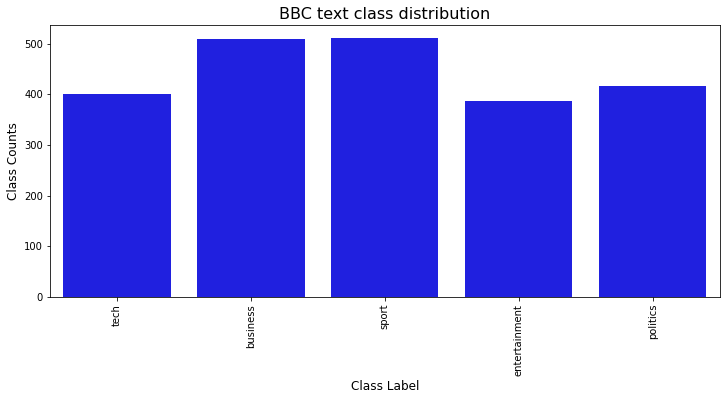

In [5]:
#Visually determine the amount of categories
plt.figure(figsize=(12,5))
sns.countplot(x=bbc_text.category, color='blue')
plt.title('BBC text class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=12)
plt.xlabel('Class Label', fontsize=12)
plt.xticks(rotation='vertical')

The illustration shows 5 categories or classes. Class distribution is mostly normal.

Lets see what type of contents are in the 'text' field of the dataset. But first I have to clean the text. I will use the following steps:

Conversion to lowercase

Removal of punctuations, extra spaces, and stopwords

Removal of intergers, numbers

Removal of tags(<html>)

Stemming

##Text Cleaning

I will use the 'gensim' library for text cleaning.

In [6]:
filters =[
          gsp.strip_tags,
          gsp.strip_punctuation,
          gsp.strip_multiple_whitespaces,
          gsp.strip_numeric,
          gsp.remove_stopwords,
          gsp.strip_short,
          gsp.stem_text
]
#Function to clean the text
def clean_text(s):
  s = s.lower()
  s = utils.to_unicode(s)
  for f in filters:
    s = f(s)
  return s



What the text looks like before cleaning.

In [7]:
#Print the first content of the text field of a record before cleaning.
bbc_text.iloc[2,1]

'tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i t

Text after cleaning.

In [8]:
#Print the first content of the text field of a record after cleaning.
clean_text(bbc_text.iloc[2,1])

'tiger wari farrel gambl leicest rush make bid andi farrel great britain rugbi leagu captain decid switch code anybodi involv process wai awai go stage tiger boss john well told bbc radio leicest moment lot unknown andi farrel medic situat go big big gambl farrel persist knee problem oper knee week ago expect month leicest saracen believ head list rugbi union club interest sign farrel decid man game union well believ better plai back initi sure step leagu union involv centr said well think england prefer progress posit row us rugbi leagu skill forward juri cross divid club balanc struck cost gambl option bring readi replac'

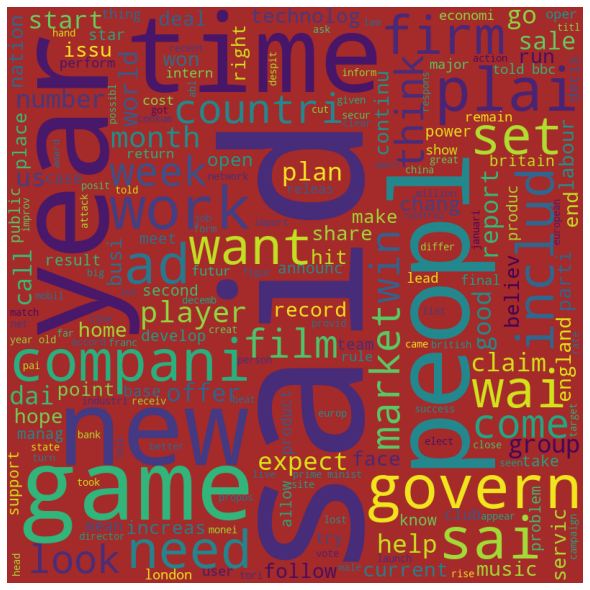

In [9]:
#Visualize 'text' content as Word Cloud
def plot_word_cloud(text):
  wordcloud_instance = WordCloud(width =800, height = 800,
                                 background_color = 'brown',
                                 stopwords=None,
                                 min_font_size = 10).generate(text)

  plt.figure(figsize = (8,8), facecolor=None)
  plt.imshow(wordcloud_instance)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  plt.show

#Concatenate all text and pass it to the function
texts = ''
for index, item in bbc_text.iterrows():
  texts = texts + ' ' + clean_text(item['text'])

plot_word_cloud(texts)

Bigger words indicate that the words appear with more frequency.
Now I will use WordCloud for a particular category.


In [10]:
#Write a generic function
def plot_word_cloud_for_cat(bbc_text, category):
    text_df = bbc_text.loc[bbc_text['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['text'])
    
    plot_word_cloud(texts)



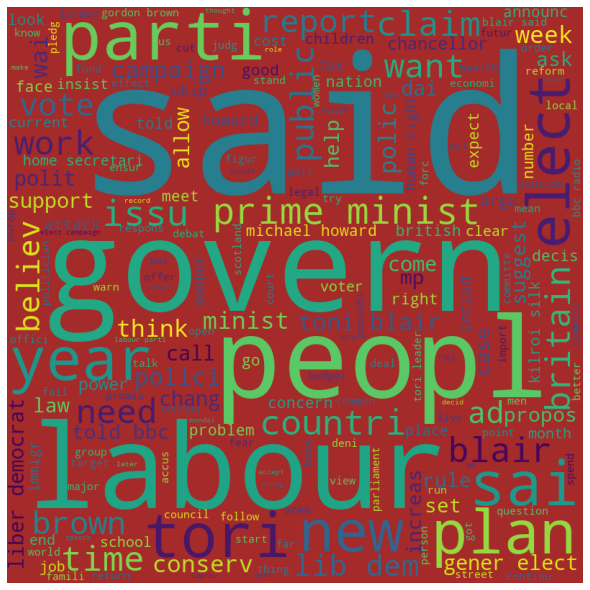

In [11]:
#Lets chech the category 'politics'
plot_word_cloud_for_cat(bbc_text,'politics')

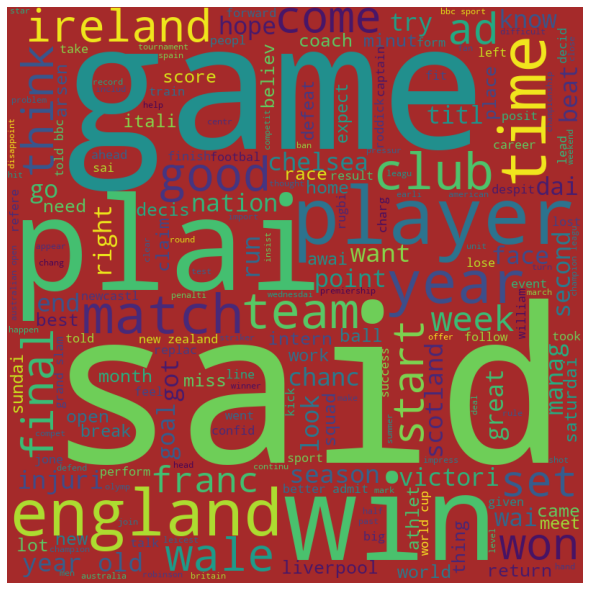

In [12]:
#And the category 'sports'
plot_word_cloud_for_cat(bbc_text,'sport')

I can see that each category has some words which are distinguishing those from other categories. Each ‘text’ is inferring some context in it which is determining its category. To confirm it, I need to do vector space analysis and use it in a model.

##Vector Space Modelling & Pipeline Building

I will try two of the most popular vector space models: Doc2Vec and Tf-Idf.

In [13]:
#Split data into features and categories.
feat_x = bbc_text['text']
cat_y = bbc_text['category']

I will use Doc2Vec API of the 'gensim library.


In [14]:
#Write generic transformer
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, feat_x, cat_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(feat_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, feat_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(feat_x)]))



In [15]:
#Apply transformer
doc2vec_trans = Doc2VecTransformer()
doc2vec_features = doc2vec_trans.fit(feat_x).transform(feat_x)
doc2vec_features

100%|██████████| 2225/2225 [00:00<00:00, 1997073.91it/s]


matrix([[ 1.3182841e-01, -1.9377729e-01, -7.9269841e-02, ...,
         -2.1161795e-01, -4.2348422e-02, -4.0175468e-01],
        [ 4.0285170e-02, -4.4894345e-02, -3.7571054e-02, ...,
         -4.2958006e-02, -1.5547674e-02, -8.8729903e-02],
        [-8.1981416e-06,  5.4215491e-03,  4.5198197e-03, ...,
         -6.7366520e-05,  5.6294603e-03,  4.0308526e-03],
        ...,
        [ 4.8814833e-02, -9.1734126e-02, -3.1784501e-02, ...,
         -1.0763719e-01, -4.4371402e-03, -1.5138736e-01],
        [ 7.6845139e-02, -6.7484722e-02, -8.1899665e-02, ...,
         -1.0565909e-01, -2.4008395e-02, -2.3275828e-01],
        [-4.3800846e-03, -4.1469778e-03, -5.4738537e-04, ...,
         -4.6013165e-03, -3.5676179e-03,  2.3479743e-03]], dtype=float32)

I get a numerical representation of the text data. I can use these numerical features with any machine learning algorithm. I will try with LogisticRegression, RandomForest & XGBoost.

For each of the cases I will do a 5-fold cross validation of the model with the dataset and test it. Accuracy score will be average of 5 folds.

Logistic Regression Pipeline

In [ ]:
#Doc2Vec and Logistic Regression Pipeline
pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, feat_x, cat_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

  0%|          | 0/1780 [00:00<?, ?it/s]

Accuracy for Logistic Regression is very low.

Random Forrest Pipeline

In [17]:
#Doc2Vec and  Random Forest Pipeline
pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, feat_x, cat_y, cv=5,scoring='accuracy')
print('Accuracy for Random Forest: ', scores.mean())

100%|██████████| 1780/1780 [00:00<00:00, 918988.32it/s]


Accuracy for Random Forest:  0.36988764044943817


Random Forest did not improve accuracy.

XGBost Pipeline


In [18]:
#Doc2Vec and  Random Forest Pipeline
pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, feat_x, cat_y, cv=5)
print('Accuracy for XGBoost: ', scores.mean())

100%|██████████| 1780/1780 [00:00<00:00, 1023141.17it/s]


Accuracy for XGBoost:  0.36089887640449436


XGBoost did not improved accuracy. 
I do not think Doc2Vec is the right process.

I will try Tf-Idf vector space model

In [19]:
#Transformer for Tf-Idf
class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, feat_x, cat_y=None):
        feat_x = feat_x.apply(lambda x : clean_text(x))
        self._model.fit(feat_x)
        return self

    def transform(self, feat_x):
        return self._model.transform(feat_x)



In [20]:
#Transform the text
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(feat_x).transform(feat_x)

#Printing its dimensions
tfidf_vectors.shape

(2225, 18755)

In [21]:
print(tfidf_vectors)

  (0, 18657)	0.026751783070208267
  (0, 18462)	0.012282569403139645
  (0, 18331)	0.06321612895581909
  (0, 18305)	0.1583605258104538
  (0, 18175)	0.03191861694040893
  (0, 18107)	0.07347900571034054
  (0, 18078)	0.0820082845034905
  (0, 18028)	0.08634135472606572
  (0, 17847)	0.024976845920106364
  (0, 17836)	0.03920692490243918
  (0, 17820)	0.0237112847547106
  (0, 17636)	0.10369692742506256
  (0, 17587)	0.058415007300576784
  (0, 17172)	0.42378247529420265
  (0, 17023)	0.04909762905009908
  (0, 16861)	0.024467110895914575
  (0, 16827)	0.012395674298416093
  (0, 16802)	0.04354600077310887
  (0, 16801)	0.1061221922410514
  (0, 16760)	0.019836834312179287
  (0, 16757)	0.02454881452504954
  (0, 16638)	0.108042004704681
  (0, 16626)	0.3048220054117621
  (0, 16529)	0.02112249983533661
  (0, 16357)	0.030876741901122738
  :	:
  (2224, 8119)	0.5554941760150036
  (2224, 8008)	0.10226374007302491
  (2224, 7456)	0.11194511747688254
  (2224, 7427)	0.0589324755687766
  (2224, 7373)	0.0462288710188

Logistic Regression

In [22]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, feat_x, cat_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Accuracy for Tf-Idf & Logistic Regression:  0.8961797752808989


Random Forest


In [23]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, feat_x, cat_y, cv=5, scoring='accuracy')
print('Accuracy for Tf-Idf & Random Forest: ', scores.mean())

Accuracy for Tf-Idf & Random Forest:  0.94561797752809


XGBoost


In [24]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, feat_x, cat_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost: ', scores.mean())

Accuracy for Tf-Idf & XGBoost:  0.9334831460674158


Tf-Idf and Random Forrest combo will be my choice for solving this problem.

#Conclusions and Results

Coc2Vec is a more advanced model in NLP, but in my case, it did not give the proper results. I tried with linear, bagging and based classifiers.

In my dataset, each ‘text’ field contains several words/tokens which are determining its category and the frequency of those is quite high. So making a context-sensitive model may over-complicate the situation or dilute this information. As the frequency of some tokens is high in some text categories, it is contributing large enough values in determining Tf-Idf. Also, ‘texts’ are domain-specific.

Doc2Vec model is more suitable for very well written grammatically correct texts. In our case, texts are quite rough in nature.
One example of grammatically correct text could be ‘Wikipedia’ texts.
It is also proven in various examples and Data Scientist’s experiments that though ‘Tf-Idf’ model is inferior as compared to ‘Doc2Vec’, but still it gives better result while classifying very domain specific texts.